Ввод данных из файла

In [1]:
import seaborn as sns
import scipy.sparse as sparse
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math as m
import triangle as tr

In [2]:
# путь к файлу
f = open("newex", "r")
all_file = f.readlines()
# Юнг, Пуассон
mu = float(all_file[0].split(' ')[0]) 
E = float(all_file[0].split(' ')[1])
# количество узлов
Num_nod = int(all_file[1])
#список узлов с координатами
Coord_nod = np.matrix([-1,-1])
for i in range(2,Num_nod + 2):
    this_line = all_file[i].split(' ')
    Coord_nod = np.append(Coord_nod,[[float(this_line[0]),float(this_line[1])]],axis = 0)
Coord_nod = np.delete(Coord_nod,0,axis = 0)
# количество конечных элементов
Num_el = int(all_file[Num_nod+2])
#список элементов с соответсвующими узлами
el_nod = np.matrix([-1,-1,-1])
for i in range(Num_nod+3,Num_nod+3+Num_el):
    this_line = all_file[i].split(' ')
    el_nod = np.append(el_nod,[[int(this_line[0]),int(this_line[1]),int(this_line[2])]],axis = 0)
el_nod = np.delete(el_nod,0,axis = 0)
print(type(el_nod))
# ограничения движения 
lim_in_nod = int(all_file[Num_nod+3+Num_el])
lim = np.matrix([-1,-1])
for i in range(Num_nod+4+Num_el,Num_nod+4+Num_el+lim_in_nod):
    this_line = all_file[i].split(' ')
    lim = np.append(lim,[[float(this_line[0]),float(this_line[1])]],axis = 0)
lim = np.delete(lim,0,axis = 0)
# количество узлов, в которых приложены усилия
eff_in_nod = int(all_file[Num_nod+4+Num_el+lim_in_nod])
eff = np.matrix([-1,-1,-1])
for i in range(Num_nod+5+Num_el+lim_in_nod,Num_nod+5+Num_el+lim_in_nod+eff_in_nod):
    this_line = all_file[i].split(' ')
    eff = np.append(eff,[[float(this_line[0]),float(this_line[1]),float(this_line[2])]],axis = 0)
eff = np.delete(eff,0,axis = 0)





<class 'numpy.matrix'>


In [3]:
# ищем матрицу D
D = E/(1 - mu*mu)*np.array([[1,mu,0],[mu,1,0],[0,0, (1-mu)/2]])
#D = E*(1-mu)/((1+mu)*(1-2*mu))*np.array([[1,mu/(1-mu),0],[mu/(1-mu),1,0],[0,0,(1-2*mu)/(2*(1-mu))]])
print(D)

[[2197.8021978   659.34065934    0.        ]
 [ 659.34065934 2197.8021978     0.        ]
 [   0.            0.          769.23076923]]


In [4]:
# убираем сингулярность
def K_ok(A,lim):
    print(lim)
    for i in range(len(lim)):
        for j in range(len(A)):
            if lim[i,0] == j:
                if lim[i,1] == 1:
                    ii = int(lim[i,0]*2)
                    for k in range(len(A)):
                        if j == k:
                            A[ii,j] = 1
                        else:
                            A[ii,j] = 0
                            A[j,ii] = 0
                if lim[i,1] == 2:
                    ii = int(lim[i,0]*2+1)
                    for k in range(len(A)):
                        if j == k:
                            A[ii,j] = 1
                        else:
                            A[ii,j] = 0
                            A[j,ii] = 0
                if lim[i,1] == 3:
                    ii1 = int(lim[i,0]*2)
                    ii0 = int(lim[i,0]*2+1)
                    
                    for k in range(len(A)):
                            A[ii1,k] = 0
                            A[k,ii1] = 0
                            A[ii0,k] = 0
                            A[k,ii0] = 0
                    A[ii1,ii1] = 1
                    A[ii0,ii0] = 1
    return A

In [5]:
#функция которой дают номера узлов, соответствующих элементу,
# и матрицу с координатами, а она считает определитель*2
def Det2(xi,yi,xj,yj,xk,yk):
    return (xj*(yk - yi) + xi*(yj - yk) + xk*(yi - yj))

In [6]:
def make_B(num,el_nod,Coord_nod,D,eff,lim):
    x,y,z = sp.symbols('x, y, z')
    ui,uj,uk = sp.var('ui uj uk')
    vi,vj,vk = sp.var('vi vj vk')
    wi,wj,wk = sp.var('wi wj wk')
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    # для конкретного элемента ищем координаты узлов
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]
    # пользуемся формулами со слайда 29
    Det = Det2(xi,yi,xj,yj,xk,yk)
    ai = (xj*yk - xk*yj)/Det
    aj = (xk*yi - xi*yk)/Det
    ak = (xi*yj - xj*yi)/Det
    bi = (yj - yk)/Det
    bj = (yk - yi)/Det
    bk = (yi - yj)/Det
    ci = (xk - xj)/Det
    cj = (xi - xk)/Det
    ck = (xj - xi)/Det
    
    # собираем матрицу B
    Bi =[[bi, 0],[0, ci],[ci, bi]]
    Bj =[[bj, 0],[0, cj],[cj, bj]] 
    Bk =[[bk, 0],[0, ck],[ck, bk]] 
    B0 = np.hstack([Bi, Bj, Bk])
    
    return B0

ВАЖНО!

In [7]:
def make_K(num,el_nod,Coord_nod,D,eff_final,lim):
    Bi = make_B(num,el_nod,Coord_nod,D,eff_final,lim)
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]

    return (Det2(xi,yi,xj,yj,xk,yk)/2)*Bi.T.dot(D).dot(Bi)

In [8]:
#make_K(0,el_nod,Coord_nod,D,eff) 

In [9]:
# глобальная K 
def sum_K(A,B,ind,num):
    a = len(A)
    b = len(B)
    for i in range(ind.shape[1]):
        for j in range(ind.shape[1]):
            ii = ind[0,i]
            jj = ind[0,j]
            A[ii*2:ii*2+2,jj*2:jj*2+2] += B[i*2:i*2+2,j*2:j*2+2]
    return A
        

с лентой я пока тоже ничего не делаю

In [10]:
# хранение полуленты
def band(A):
    n = len(A)
    B = np.zeros((n,6))
    A = np.block([A, np.zeros((n,5))])
    for i in range(n):
        B[i,:] = A[i,i:6+i]
    return B

In [11]:
# распаковка полуленты
def band_out(A):
    n = len(A)
    A = np.block([[A, np.zeros((n,n))]])
    B = np.zeros((n,n*2))
    for i in range(n):
        for j in range(n):
            B[i,i+j] = A[i,j]
            B[i,i-j] = B[i-j,i]
    
        
    return B[:,:n]

In [12]:
# генерируем вектор правых частей
def right(eff,num_nod):
    a = np.zeros(Num_nod*2)
    for i in range(len(eff)):
        for j in range(Num_nod):
            if eff[i,0] == j:
                a[j*2] = eff[i,1]
                a[j*2+1] = eff[i,2]
            
    return a

In [13]:
def FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim):
    rig = right(eff,Num_nod)
    K0 = np.zeros((Num_nod*2,Num_nod*2))
    for i in range(0,Num_el):
        ind = el_nod[i,:]
        K0 = sum_K(K0,make_K(i,el_nod,Coord_nod,D,eff,lim),ind[0],i)
    K0 = K_ok(K0,lim)

    U = np.linalg.solve(K0,rig.T)
    #достать перемещения можно где-то здесь
    max_sig = 0
    max_sig_i = -1
    m_s=0
    m_s_i=-1
    lnap = np.matrix([-1,-1,-1])
    for i in range(Num_el):
        B = make_B(i,el_nod,Coord_nod,D,eff,lim)
        Ui = np.zeros((6))
        Ui[0] = U[el_nod[i,0]*2]
        Ui[1] = U[el_nod[i,0]*2+1]
        Ui[2] = U[el_nod[i,1]*2]
        Ui[3] = U[el_nod[i,1]*2+1]  
        Ui[4] = U[el_nod[i,2]*2]
        Ui[5] = U[el_nod[i,2]*2+1] 
        #деформации (эпсилон)    
        Eps = B.dot(Ui)
        # напряжения(сигма)
        Nap = D.dot(Eps) 
        lnap = np.append(lnap,[[Nap[0],Nap[1],Nap[2]]],axis=0)
        NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])
        
        Sig,s = np.linalg.eig(NapM) 
        
        now_sig = m.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
        if now_sig > max_sig:
            max_sig = now_sig
            max_sig_i = i
        
        #now_sig = max(abs(Sig))
        #if n_s > m_s:
         #   m_s = n_s
          #  m_s_i = i
        #print('Модуль максимального главного напряжения ',max(abs(Sig)))
        #print('Деформации в ',i,' элементе',Eps)
        #print('Напряжения в ',i,' элементе',Nap)
    print(max_sig)
    a = Coord_nod[el_nod[max_sig_i,0],:]
    b = Coord_nod[el_nod[max_sig_i,1],:]
    c = Coord_nod[el_nod[max_sig_i,2],:]

    plt.plot(Coord_nod[:,0],Coord_nod[:,1],'.')
    plt.plot(b[0,0],b[0,1],'r.')
    plt.plot(a[0,0],a[0,1],'r.')
    plt.plot(c[0,0],c[0,1],'r.')
    lnap = np.delete(lnap,0,axis = 0)

    return np.hstack([U[0*2:10*2],U[264*2:274*2]]),lnap


In [14]:
f.close()

[]
20.296925707380563


(array([-6.50555180e+09,  2.14362883e+10, -1.02187280e+10,  2.02298042e+10,
        -1.25135971e+10,  1.70711879e+10, -1.25135971e+10,  1.31669234e+10,
        -1.02187280e+10,  1.00083071e+10, -6.50555180e+09,  8.80182306e+09,
        -2.79237563e+09,  1.00083071e+10, -4.97506549e+08,  1.31669234e+10,
        -4.97506549e+08,  1.70711879e+10, -2.79237563e+09,  2.02298042e+10,
        -1.39886590e+09, -5.97707451e+08, -1.98750291e+10,  5.40556188e+09,
         1.00200309e+10,  1.51190557e+10, -1.39886590e+09,  3.08358188e+10,
        -1.98750291e+10,  2.48325495e+10, -1.13999043e+10,  5.57874586e+07,
         6.30802949e+09,  2.44286674e+10,  6.30802949e+09,  5.80944394e+09,
        -1.13999043e+10,  3.01823239e+10, -2.23440093e+10,  1.51190557e+10]),
 matrix([[-10.65086692,  -1.1197517 ,   0.41081355],
         [ 13.95089286,  -5.58035714,   6.00961538],
         [-10.35585508,  -1.15363152,  -0.56340144],
         ...,
         [-10.11439732,  -0.34877232,   0.7042518 ],
         [ -

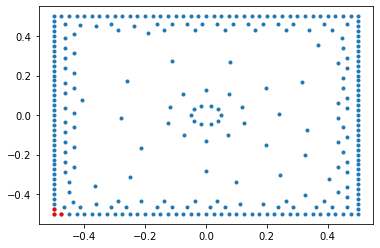

In [15]:
FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim)

рассмотрим две подобласти для локального решения задачи: круглую и квадратную
как задавать их?
скорее всего, неравенствами

In [16]:
def circleLoc(o,r):
    ram = []
    coord = [0,0]
    for i in range(len(Coord_nod)):
        if m.sqrt((o[1] - Coord_nod[i,1])**2+(o[0] - Coord_nod[i,0])**2)<=r :
            plt.plot(Coord_nod[i,0],Coord_nod[i,1],'r.')
            coord = np.vstack([coord,Coord_nod[i,:]])
            ram = np.append(ram,i)
            print(i)
    coord = np.delete(coord,0,axis=0)
    return np.array(ram),np.array(coord)

0
1
2
3
4
5
6
7
8
9
264
265
266
267
268
269
270
271
272
273


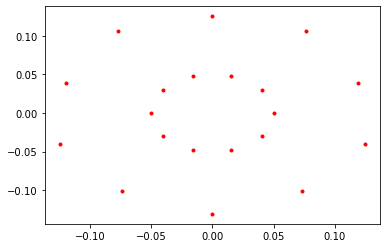

In [17]:
s,pts = circleLoc([0,0],0.2)

[]
20.296925707380563


matrix([[-6.50555180e+09,  2.14362883e+10, -1.02187280e+10,
          2.02298042e+10, -1.25135971e+10,  1.70711879e+10,
         -1.25135971e+10,  1.31669234e+10, -1.02187280e+10,
          1.00083071e+10, -6.50555180e+09,  8.80182306e+09,
         -2.79237563e+09,  1.00083071e+10, -4.97506549e+08,
          1.31669234e+10, -4.97506549e+08,  1.70711879e+10,
         -2.79237563e+09,  2.02298042e+10, -1.39886590e+09,
         -5.97707451e+08, -1.98750291e+10,  5.40556188e+09,
          1.00200309e+10,  1.51190557e+10, -1.39886590e+09,
          3.08358188e+10, -1.98750291e+10,  2.48325495e+10,
         -1.13999043e+10,  5.57874586e+07,  6.30802949e+09,
          2.44286674e+10,  6.30802949e+09,  5.80944394e+09,
         -1.13999043e+10,  3.01823239e+10, -2.23440093e+10,
          1.51190557e+10]])

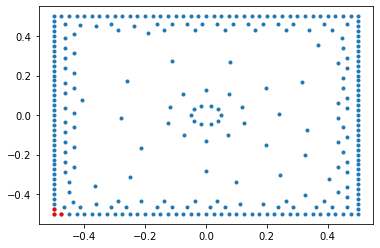

In [18]:
new_lim1,oldnap = FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim)
new_lim1= np.matrix(new_lim1)
new_lim1

делаем новую сетку


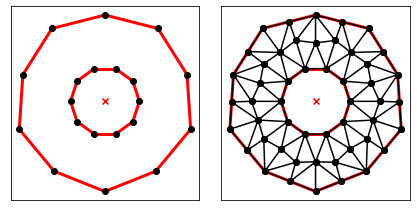

<class 'numpy.matrix'>


In [148]:

seg = np.vstack([np.array([[i,i+1] for i in range(9)]),[[9,0],[10,15],[15,11],[11,19],[19,14],[14,18],[18,13],[13,16],[16,12],[12,17],[17,10]]])
A = dict(vertices=pts,segments = seg,holes = [[0,0]])
B = tr.triangulate(A,'qpa0.001')
tr.compare(plt, A, B)
plt.show()
Coord_nod1 = np.matrix(B['vertices'])
Num_nod1 = len(B['vertices'])
el_nod1 = np.matrix(B['triangles'])
print(type(el_nod))
Num_el1 = len(B['triangles'])


In [149]:


lim = np.matrix([-1,-1])
for i in range(40):
    lim = np.append(lim,[[i,new_lim1[0,i]]],axis = 0)
lim = np.delete(lim,0,axis = 0)
print(lim)
eff = np.matrix([-1,-1,-1])
#for i in range(Num_nod):
 #   eff = np.append(eff,[[i,0,0]],axis = 0)
#eff = np.delete(eff,0,axis = 0)


[[ 0.00000000e+00 -6.50555180e+09]
 [ 1.00000000e+00  2.14362883e+10]
 [ 2.00000000e+00 -1.02187280e+10]
 [ 3.00000000e+00  2.02298042e+10]
 [ 4.00000000e+00 -1.25135971e+10]
 [ 5.00000000e+00  1.70711879e+10]
 [ 6.00000000e+00 -1.25135971e+10]
 [ 7.00000000e+00  1.31669234e+10]
 [ 8.00000000e+00 -1.02187280e+10]
 [ 9.00000000e+00  1.00083071e+10]
 [ 1.00000000e+01 -6.50555180e+09]
 [ 1.10000000e+01  8.80182306e+09]
 [ 1.20000000e+01 -2.79237563e+09]
 [ 1.30000000e+01  1.00083071e+10]
 [ 1.40000000e+01 -4.97506549e+08]
 [ 1.50000000e+01  1.31669234e+10]
 [ 1.60000000e+01 -4.97506549e+08]
 [ 1.70000000e+01  1.70711879e+10]
 [ 1.80000000e+01 -2.79237563e+09]
 [ 1.90000000e+01  2.02298042e+10]
 [ 2.00000000e+01 -1.39886590e+09]
 [ 2.10000000e+01 -5.97707451e+08]
 [ 2.20000000e+01 -1.98750291e+10]
 [ 2.30000000e+01  5.40556188e+09]
 [ 2.40000000e+01  1.00200309e+10]
 [ 2.50000000e+01  1.51190557e+10]
 [ 2.60000000e+01 -1.39886590e+09]
 [ 2.70000000e+01  3.08358188e+10]
 [ 2.80000000e+01 -1

In [150]:
# умножение матрицы на матрицу
def d(A,B):
    
    ans = np.zeros((A.shape[0],B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(B.shape[0]):
                ans[i,j] += A[i,k] * B[k,j]
    return ans

In [151]:
def FEM1(el_nod,Coord_nod,D,eff,Num_nod,Num_el,lim):
    rig = right(eff,Num_nod)
    K0 = np.zeros((Num_nod*2,Num_nod*2))
    for i in range(0,Num_el):
        ind = el_nod[i,:]
        K0 = sum_K(K0,make_K(i,el_nod,Coord_nod,D,eff,lim),ind[0],i)
   
    #делаем то, что написовала на листочке
    K2 = K0[40:,:40]
  
    rig = d(K2,new_lim1)
    rig = np.sum(rig,axis=1)
    K1 = K0[40:,40:]
    
    
    #K0 = K_ok(K0,lim)

    U = np.linalg.solve(K1,-rig.T)
    
    U = np.hstack([np.array(new_lim1[0]),[U]])[0]

    #достать перемещения можно где-то здесь
    max_sig = 0
    max_sig_i = -1
    m_s=0
    m_s_i=-1
    lnap = [-1,-1,-1]
    outnap = np.matrix([-1,-1,-1])
    for i in range(Num_el):
        B = make_B(i,el_nod,Coord_nod,D,eff,lim)
        Ui = np.zeros((6))
        Ui[0] = U[el_nod[i,0]*2]
        Ui[1] = U[el_nod[i,0]*2+1]
        Ui[2] = U[el_nod[i,1]*2]
        Ui[3] = U[el_nod[i,1]*2+1]  
        Ui[4] = U[el_nod[i,2]*2]
        Ui[5] = U[el_nod[i,2]*2+1] 
        #деформации (эпсилон)    
        Eps = B.dot(Ui)
        # напряжения(сигма)
        Nap = D.dot(Eps) 
        if i in range(20):
            outnap = np.append(outnap,[[Nap[0],Nap[1],Nap[2]]],axis=0)
        lnap = np.append(lnap,[Nap[0],Nap[1],Nap[2]])
        NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])
        
        Sig,s = np.linalg.eig(NapM) 
        
        now_sig = m.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
        if now_sig > max_sig:
            max_sig = now_sig
            max_sig_i = i
        #now_sig = max(abs(Sig))
        #if n_s > m_s:
         #   m_s = n_s
          #  m_s_i = i
        #print('Модуль максимального главного напряжения ',max(abs(Sig)))
        #print('Деформации в ',i,' элементе',Eps)
        #print('Напряжения в ',i,' элементе',Nap)
    print(max_sig)
    a = Coord_nod[el_nod[max_sig_i,0],:]
    b = Coord_nod[el_nod[max_sig_i,1],:]
    c = Coord_nod[el_nod[max_sig_i,2],:]

    plt.plot(Coord_nod[:,0],Coord_nod[:,1],'.')
    plt.plot(b[0,0],b[0,1],'r.')
    plt.plot(a[0,0],a[0,1],'r.')
    plt.plot(c[0,0],c[0,1],'r.')
    outnap = np.delete(outnap,0,axis = 0)

    return outnap

3701764348645643.0


matrix([[ 1.15964304e+14, -2.09987516e+14, -3.76274102e+13],
        [ 2.29839600e+15,  5.23915652e+14,  7.15580371e+13],
        [ 1.61744172e+14, -6.45922925e+14,  3.83997259e+13],
        [-2.95676626e+14, -1.70497740e+13, -7.12490985e+13],
        [ 6.15408557e+14,  1.85569265e+14, -4.08544157e+13],
        [-2.44823450e+14, -3.27875280e+14, -1.59193813e+14],
        [ 6.42829114e+14,  1.39998825e+15, -4.73864886e+14],
        [-3.95878736e+14, -3.08951584e+14,  2.11784557e+14],
        [-6.55356661e+13, -9.46299949e+14,  2.93847637e+14],
        [ 3.91164120e+14,  1.14318499e+14,  1.76332301e+14],
        [ 1.97341708e+14,  4.42568882e+14,  1.41310149e+14],
        [-1.38188312e+14,  2.91560099e+13,  6.52233948e+13],
        [-6.15630277e+14, -5.29864573e+14,  3.38207020e+14],
        [-5.76901761e+14, -2.54149426e+14,  1.58541726e+14],
        [ 6.13535827e+13,  4.71100156e+13,  3.37468895e+13],
        [ 1.26606015e+15,  4.65423101e+14, -2.45262936e+14],
        [ 2.45274989e+14

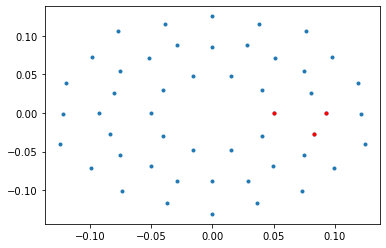

In [152]:
newnap = FEM1(el_nod1,Coord_nod1,D,eff,Num_nod1,Num_el1,lim)
newnap

In [153]:
for i in range(10):
    oldnap[i,:] = oldnap[i,:]+newnap[i,:]
for i in range(10,20):
    for j in range(264,274):
        oldnap[i,:] = oldnap[i,:]+newnap[i,:]

In [154]:
oldnap

matrix([[ 1.15964304e+14, -2.09987516e+14, -3.76274102e+13],
        [ 2.29839600e+15,  5.23915652e+14,  7.15580371e+13],
        [ 1.61744172e+14, -6.45922925e+14,  3.83997259e+13],
        ...,
        [-1.01143973e+01, -3.48772321e-01,  7.04251803e-01],
        [-9.62645143e+00,  8.96244259e-01,  1.10332782e+00],
        [-1.03072282e+01,  1.27436041e-01,  4.46026142e-01]])

1.1877436798364604e+16


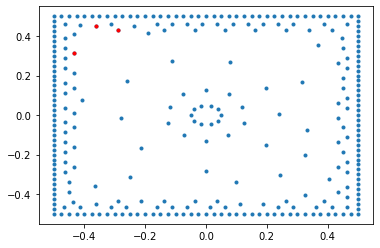

In [155]:
max_sig = -100
for i in range(len(oldnap)):
    NapM = np.matrix([[oldnap[i,0],oldnap[i,2]],[oldnap[i,2],oldnap[i,1]]])
    Sig,s = np.linalg.eig(NapM) 
        
    now_sig = m.sqrt(oldnap[i,0]**2-oldnap[i,0]*oldnap[i,1]+oldnap[i,1]**2+3*oldnap[i,2]**2)
    if now_sig > max_sig:
        max_sig = now_sig
        max_sig_i = i
print(max_sig)
a = Coord_nod[el_nod[max_sig_i,0],:]
b = Coord_nod[el_nod[max_sig_i,1],:]
c = Coord_nod[el_nod[max_sig_i,2],:]

plt.plot(Coord_nod[:,0],Coord_nod[:,1],'.')
plt.plot(b[0,0],b[0,1],'r.')
plt.plot(a[0,0],a[0,1],'r.')
plt.plot(c[0,0],c[0,1],'r.')